In [1]:
from torchvision import datasets, transforms
from torch.utils import data

In [2]:
train_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=True, download=True,
                         transform=transforms.Compose([
                             #증폭 추가
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=32
)
                          


In [3]:
test_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=False, download=True,
                         transform=transforms.Compose([
                             #증폭 추가
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=32
)
                

In [4]:
len(train_loader), len(test_loader) #배치사이즈 32여서 각 길이에 * 32 해주면 됨
# 대충 6만개 1만개해서 7만개 -> 잘 했음

(1875, 313)

In [5]:
images, labels = next(iter(train_loader))
images.shape #4개의 값 , batch_size, channel, height, width -> 넓이

torch.Size([32, 1, 28, 28])

In [6]:
labels.shape

torch.Size([32])

In [7]:
images[0].shape

torch.Size([1, 28, 28])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
import torch
torch_image = torch.squeeze(images[0]) #1을 제거 후 28,28 로 시각화를 해보기 위해 squeeze()함수 사용
torch_image.shape

torch.Size([28, 28])

In [10]:
torch_image.numpy()

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    

In [11]:
import os # kernel error 발생 시 추가
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

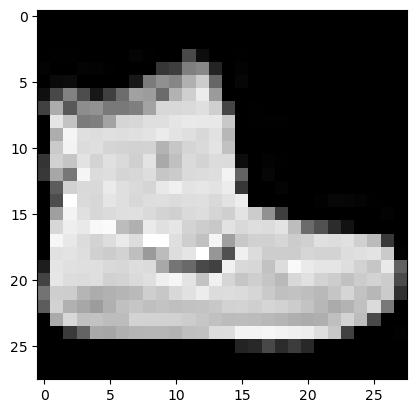

In [12]:
plt.imshow(torch_image.numpy(), 'gray')
plt.show()

In [14]:
#CNN 모델 구조
#입력데이터 -> (합성곱 -> 풀링 -> 활성화 함수)반복 -> 평탄화 -> 전결합 레이어 -> 전결합 레이어 -> 분류 결과
#CNN 모델 구현
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [16]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        self.conv1 = nn.Conv2d(1,10,5) #입력 채널, 출력채널, 커널사이즈, 보폭(기본값 1)
        self.conv2 = nn.Conv2d(10,20,5)
        self.drop = nn.Dropout2d() # 출력값에 Dropout 적용
        self.fc1 = nn.Linear(320,160) # 입력 레이어의 입력값
        self.fc2 = nn.Linear(160,80) # 히든레이어
        self.fc3 = nn.Linear(80,10) # 출력레이어 10인 이유 10개 중 1개 분류하는거라
    def forward(self, x):
        x = f.relu(f.max_pool2d(self.conv1(x),2)) #안에서 부터 시작
        # Conv -> max_pool -> ReLU
        x= f.relu(f.max_pool2d(self.drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.dropout(x, training=self.training)
        x = f.relu(self.fc3(x))
        return x

In [24]:
model = Cnn().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [25]:
predictions = []
targets = []
EPOCHS = 30 #학습 횟수
for epoch in range(1, EPOCHS+1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, tarage = data.to(device), target.to(device) #학습 데이터를 device 메모리로 전달
        optimizer.zero_grad() #기울기 초기화
        output = model(data) #output은 모델의 예측값
        loss = f.cross_entropy(output, target) #예측값과 실제값의 오차 계산
        loss.backward() #기울기 계산
        optimizer.step() #최적화 알고리즘으로 가중치 수정
    print(f"Train Epoch : {epoch} \t Loss : {loss.item()}") #학습을 하면 할 수록 오차가 줄어드는 것을 볼 수 있음
    
    model.eval() #검증 모드 validation
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #검증 할 때는기울기 계산할 필요 없음
        for data, target in test_loader: #테스트 데이터만큼 반복
            data, target = data.to(device), target.to(device) #데이터 device 메모리로 전달
            output = model(data) #모델의 예측값
            test_loss += f.cross_entropy(output, target, reduction='sum').item() #모든 오차의 합 계산
            pred = output.argmax(dim=1, keepdim=True) #차원, 차원유지 옵션 , #가장 큰 값이 모델의 예측값
            correct += pred.eq(target.view_as(pred)).sum().item() #예측값과 실제값이 같은 경우 1 더함
            #반복이 끝나면 correct는 정답을 맞춘 갯수
            pred = pred.detach().cpu().numpy()
            target = target.detach().cpu().numpy()
            for i in range(len(pred)):
                predictions.append(pred[i])
                targets.append(target[i])
                
    test_loss /= len(test_loader.dataset)
    
    print(f"Test set : Average Loss {test_loss}, Accuracy : {correct/len(test_loader.dataset)*100}") #백분율로 정확도 출력

Train Epoch : 1 	 Loss : 0.8340395092964172
Test set : Average Loss 0.8101709948539734, Accuracy : 70.75
Train Epoch : 2 	 Loss : 0.84764164686203
Test set : Average Loss 0.6395323948860169, Accuracy : 75.14
Train Epoch : 3 	 Loss : 0.7327413558959961
Test set : Average Loss 0.585728041267395, Accuracy : 76.69
Train Epoch : 4 	 Loss : 0.6383975744247437
Test set : Average Loss 0.5482423441886902, Accuracy : 78.07
Train Epoch : 5 	 Loss : 0.5794485807418823
Test set : Average Loss 0.5092884730815888, Accuracy : 80.62
Train Epoch : 6 	 Loss : 0.713817834854126
Test set : Average Loss 0.49600192198753357, Accuracy : 80.89
Train Epoch : 7 	 Loss : 0.5247495174407959
Test set : Average Loss 0.47335277967453004, Accuracy : 82.23
Train Epoch : 8 	 Loss : 0.5518910884857178
Test set : Average Loss 0.4539346468925476, Accuracy : 83.34
Train Epoch : 9 	 Loss : 0.5787336230278015
Test set : Average Loss 0.43800988593101503, Accuracy : 83.97
Train Epoch : 10 	 Loss : 0.487368106842041
Test set : A

In [20]:
datas, labels = next(iter(test_loader))

In [21]:
data[0].shape, labels[0]

(torch.Size([1, 28, 28]), tensor(9))

In [22]:
pred = model(datas)
pred[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 12.1589,  0.0000, 14.4615,
         4.1753, 18.7540], grad_fn=<SelectBackward0>)

In [23]:
pred[0].argmax()

tensor(9)

In [30]:
#성능평가 지표 2가지 , 분류모델에 적용 가능
    #혼동 행렬 - 사이킷 런 라이브러리에 있음
from sklearn.metrics import confusion_matrix
confusion_matrix(targets,predictions)


array([[25247,    14,   789,  1390,   120,    53,  1980,     1,   406,
            0],
       [   35, 28580,    35,  1050,   148,    37,    84,     0,    31,
            0],
       [  410,     5, 23488,   380,  3622,    55,  1911,     2,   127,
            0],
       [  907,   127,   346, 26547,  1022,     0,   966,     0,    84,
            1],
       [   30,    13,  2573,  1290, 23889,     4,  2091,     0,   110,
            0],
       [   17,     1,     0,    66,     0, 26804,     1,  2333,   112,
          666],
       [ 6475,    13,  4608,  1064,  3097,    33, 14050,     1,   659,
            0],
       [    0,     0,     0,     0,     0,   392,     0, 28550,    14,
         1044],
       [   66,    19,   262,   164,   124,   177,   361,   194, 28612,
           21],
       [    4,     0,     0,    17,     1,   208,     1,  1826,    26,
        27917]])

In [29]:
    #분류 보고서
from sklearn.metrics import classification_report
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80     30000
           1       0.99      0.95      0.97     30000
           2       0.73      0.78      0.76     30000
           3       0.83      0.88      0.86     30000
           4       0.75      0.80      0.77     30000
           5       0.97      0.89      0.93     30000
           6       0.66      0.47      0.55     30000
           7       0.87      0.95      0.91     30000
           8       0.95      0.95      0.95     30000
           9       0.94      0.93      0.94     30000

    accuracy                           0.85    300000
   macro avg       0.84      0.85      0.84    300000
weighted avg       0.84      0.85      0.84    300000

